In [2]:
import sys
import os
import pandas as pd
import geopandas as gpd
current_file_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_file_path,'..'))  # ,'..','..'
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from load_inputs.Lyon.weather import load_data as load_data_subway_in,START, END,FILE_NAME

info_stations = {69029001: {'lat': 45.72583,
                           'lon': 4.937777,
                           'name': 'Lyon-Bron'},
                    69299001: {'lat': 45.72639, 
                            'lon': 5.077777,
                            'name': 'Lyon—St Exupery'}}

# lat = "45°43'33“N"
# lon = "4°56'16“E"

# lat	 = "45°43'35“N"
# lat	 = "5°04'40“E"

# convert into gdf:
gdf_info_stations = pd.DataFrame.from_dict(info_stations, orient='index')
gdf_info_stations.index.name = 'station_id'
gdf_info_stations.reset_index(inplace=True)
gdf_info_stations['lat'] = gdf_info_stations['lat'].astype(float)
gdf_info_stations['lon'] = gdf_info_stations['lon'].astype(float)
gdf_info_stations['geometry'] = gdf_info_stations.apply(lambda row: (row['lat'], row['lon']), axis=1)
gdf_info_stations = gpd.GeoDataFrame(gdf_info_stations, geometry=gpd.points_from_xy(gdf_info_stations['lon'], gdf_info_stations['lat']), crs="EPSG:4326")
gdf_info_stations.explore(tiles= 'Carto DB positron', zoom_start=10)



# Load Data

In [4]:


from load_inputs.Lyon.weather import load_data as load_data_subway_in,START, END,FILE_NAME
from pipeline.plotting.TS_analysis import plot_TS
from argparse import Namespace
from examples.benchmark import local_get_args
from constants.paths import FOLDER_PATH

invalid_dates = []
minmaxnorm = True
standardize = False  # Set to True if you want to standardize the data
config = {'model_name': 'STGCN',
         'freq' : '15min',
        'dataset_names':['weather'],
        'dataset_for_coverage' : ['subway_in'],
        'target_data': 'weather',
        'contextual_kwargs':{'weather':{},
                           },
        'target_kwargs':{'weather':{'quantile_filter_outliers':0.995,}},
        'step_ahead':1,
        'horizon_step':1,
        }

args = local_get_args(config['model_name'],
                args_init = None,
                dataset_names=config['dataset_names'],
                dataset_for_coverage=config['dataset_for_coverage'],
                modification = config)



coverage_period = pd.date_range(start=START, end=END, freq='15min')[:-1]  # Exclude the last date to match the data
args_out = Namespace(**vars(args))  
args_out.target_data = 'weather'
args_out.dataset_for_coverage = ['weather']
args_out.dataset_names = ['weather']
args_out.contextual_kwargs = {}


ds = load_data_subway_in(FOLDER_PATH, coverage_period=coverage_period, invalid_dates=invalid_dates, args=args_out, minmaxnorm=minmaxnorm,standardize=standardize, normalize=True,filename=FILE_NAME,
              tensor_limits_keeper = None)

df_raw = pd.DataFrame(ds.raw_values,columns = ds.spatial_unit, index = ds.df_dates['date'])
# df =  pd.DataFrame(ds.U_train[:,:,-1].detach().cpu().numpy(),columns = ds.spatial_unit, index = ds.tensor_limits_keeper.df_verif_train.iloc[:,-2] )
df = df_raw[(df_raw.index <=pd.to_datetime("2020-01-01")) &
        (df_raw.index >=pd.to_datetime("2019-01-01"))
        ]
df.columns.name = 'Spatial Unit ID'
df.index.name = 'date'

from pipeline.plotting.TS_analysis import plot_TS

plot_TS(list_df_ts=df,width = 1200,height=400,bool_show= True,
        title = 'Rainfall Intensity (mm/h) - Lyon - NetMob Dataset',
        )

Values with issues:  0.001%
Regular Values that we have to set to 0:  0.000%
Values with issues:  0.014%
Regular Values that we have to set to 0:  0.000%


Loading BokehJS ...

figure(id='p1001', ...)

Number of remaining time-slots after filtering 3355
Number of remaining time-slots after filtering 2040


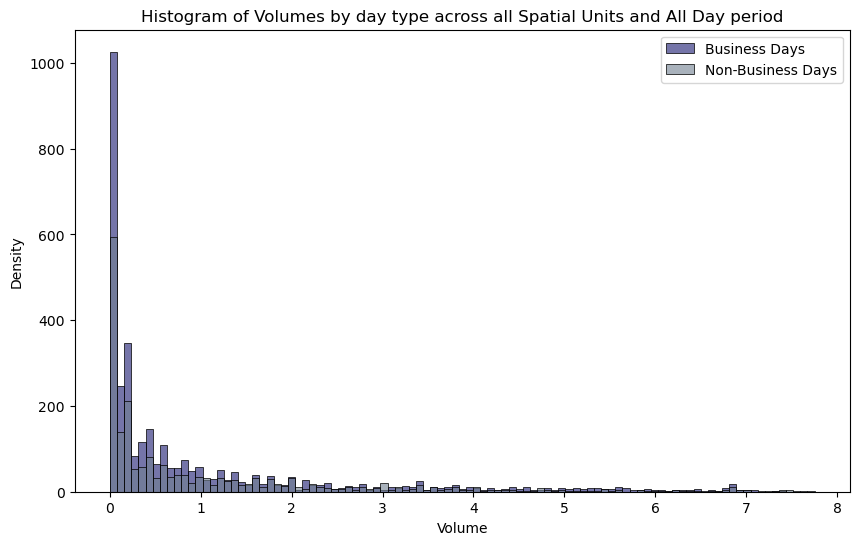

Number of remaining time-slots after filtering 3355
Number of remaining time-slots after filtering 2040


<Figure size 1200x600 with 0 Axes>

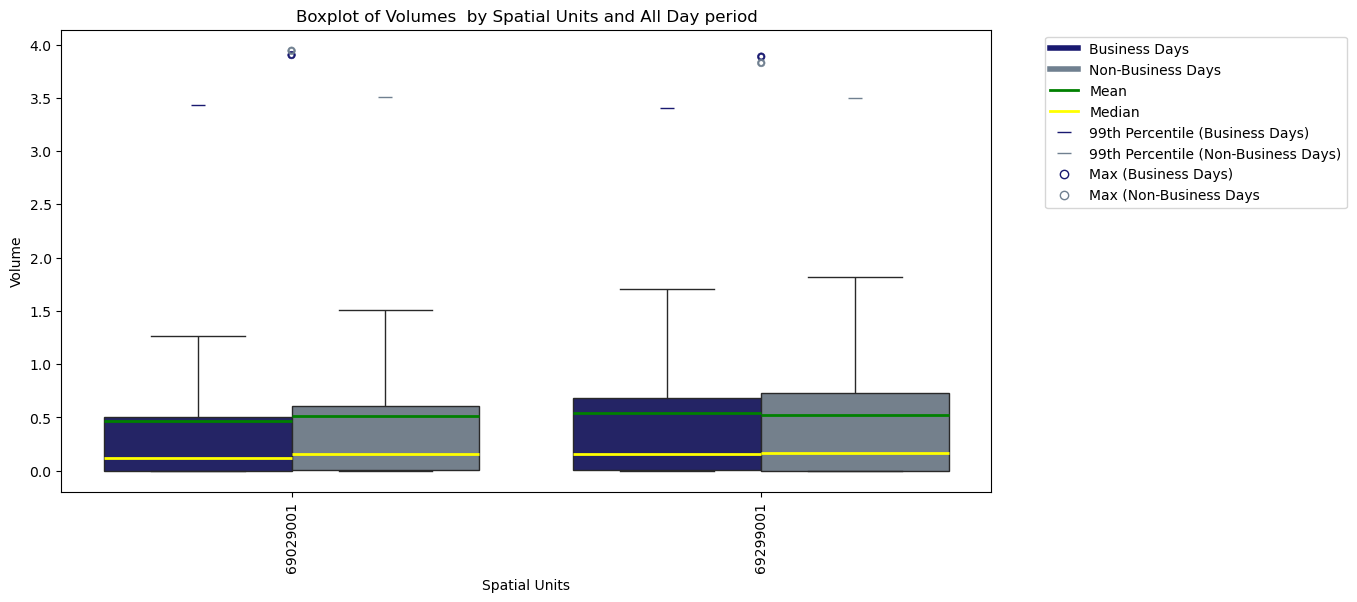

In [3]:
from load_inputs.systematic_analysis.utils import get_histogram_per_day_type,get_boxplot_per_spatial_unit_per_day_type,heatmap
from load_inputs.systematic_analysis.utils import IN_bdc,OUT_bdc,IN_nbdc,OUT_nbdc
city = 'Lyon'
palette = [IN_bdc, IN_nbdc]
stats = 'count'

df_positiv = df[df.sum(axis=1)>0]
ts_bd, ts_nbd = get_histogram_per_day_type(df_positiv,city= city,period = 'all_day',stats = stats, palette = palette,n_bins = 100)

df_bd, df_nbd = get_boxplot_per_spatial_unit_per_day_type(df_positiv,period = 'all_day',city= city, palette = palette)

/tmp/ipykernel_26383/2704948283.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ts = ts .applymap(lambda x: 0 if x < 0.05 else x)


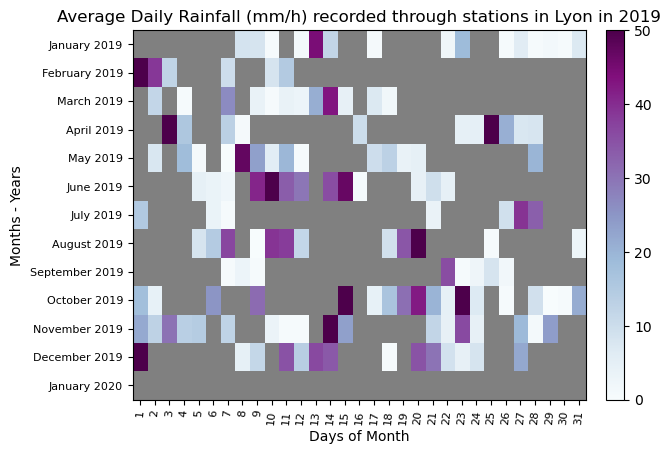

In [11]:
cmap = 'BuPu' # 'hot' #'YlOrRd' # 'RdYlBu'
bool_reversed= False 
ts = pd.DataFrame(df.mean(axis= 1))

# Filter out low rainfall values
ts = ts .applymap(lambda x: 0 if x < 0.05 else x)
df_agg = heatmap(ts,
                 city= city,
                 cmap = cmap,
                 filter_q = 0.99,
                 bool_reversed = bool_reversed,
                 vmin = 0,
                 vmax = 50,
                 title = 'Average Daily Rainfall (mm/h) recorded through stations in Lyon in 2019'
                 )

In [26]:
# convert latitude: 
# Longitude	4°56'16“E
def dms_to_dd(dms):
    degrees = int(dms.split('°')[0])
    minutes = int(dms.split('°')[1].split("'")[0])
    seconds = int(dms.split("'")[1][:-2])
    direction = dms[-1]

    dd = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# lat = "45°43'33“N"
# lon = "4°56'16“E"
lat	 = "45°43'35“N"
lon	 = "5°04'40“E"
lat_dd = dms_to_dd(lat)
lon_dd = dms_to_dd(lon)
print(f"Latitude in decimal degrees: {lat_dd}")
print(f"Longitude in decimal degrees: {lon_dd}")
 

N
E
Latitude in decimal degrees: 45.72638888888889
Longitude in decimal degrees: 5.0777777777777775
